In [1]:
# Install necessary libraries (if not already installed)
!pip install -q pandas numpy scikit-learn matplotlib seaborn kaggle

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Kaggle API for dataset download
from google.colab import files

# Upload kaggle.json file from local machine
print("Upload kaggle.json API token file from your Kaggle account")
files.upload()

# Move kaggle.json to the correct folder and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Credit Card Fraud Detection dataset from Kaggle
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzip the dataset
!unzip -q creditcardfraud.zip

# Check extracted files
!ls


Upload kaggle.json API token file from your Kaggle account


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.40GB/s]
creditcard.csv	creditcardfraud.zip  kaggle.json  sample_data


In [2]:
# Step 2: Load the Dataset

# Load the credit card transactions dataset
df = pd.read_csv('creditcard.csv')

# Display the first few rows of the dataset
print(df.head())

# Basic info about dataset: shape, columns, missing values
print("\nDataset Shape:", df.shape)
print("\nColumns:", df.columns)
print("\nMissing values:\n", df.isnull().sum())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

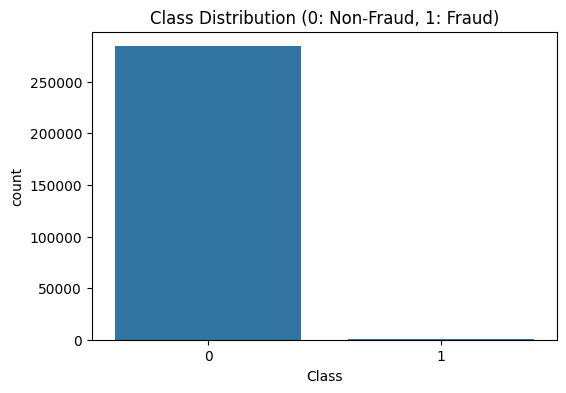

Fraudulent transactions percentage: 0.1727%


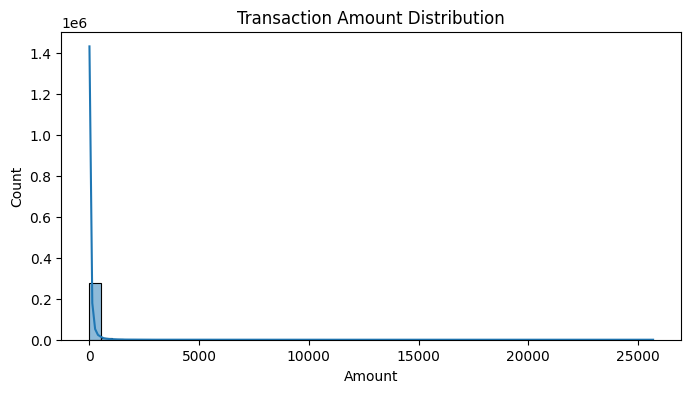

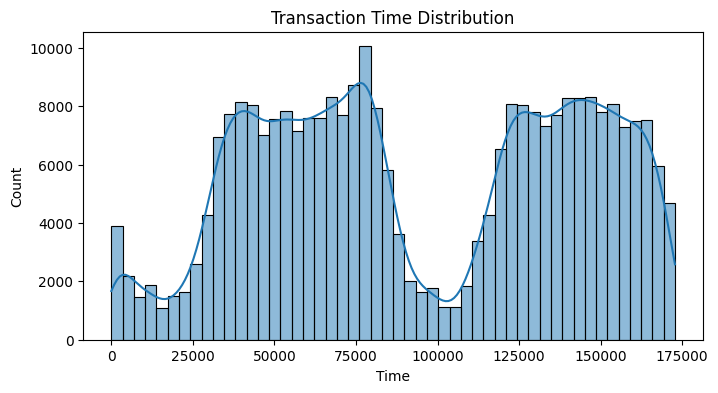

In [3]:
# Step 3: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the class distribution (fraud vs non-fraud)
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.show()

# Percentage of fraud vs non-fraud
fraud_percentage = df['Class'].mean() * 100
print(f'Fraudulent transactions percentage: {fraud_percentage:.4f}%')

# Plot distribution of transaction amount
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

# Plot distribution of transaction time
plt.figure(figsize=(8,4))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Transaction Time Distribution')
plt.show()


In [4]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 4: Data Preprocessing

# Scale 'Amount' and 'Time' features using StandardScaler
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time_scaled'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop original 'Amount' and 'Time' columns (optional)
df = df.drop(['Amount', 'Time'], axis=1)

# Separate features and target label
X = df.drop('Class', axis=1)
y = df['Class']

# Check class distribution before balancing
print('Original dataset shape:', Counter(y))

# Use SMOTE to oversample the minority class (fraud cases)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after balancing
print('Resampled dataset shape:', Counter(y_resampled))


Original dataset shape: Counter({0: 284315, 1: 492})
Resampled dataset shape: Counter({0: 284315, 1: 284315})


In [5]:
from sklearn.model_selection import train_test_split

# Step 6: Split Data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)


Training set shape: (454904, 30)
Testing set shape: (113726, 30)


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     56863
           1       0.97      0.92      0.95     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726

Confusion Matrix:
 [[55446  1417]
 [ 4453 52410]]
ROC AUC Score: 0.9895


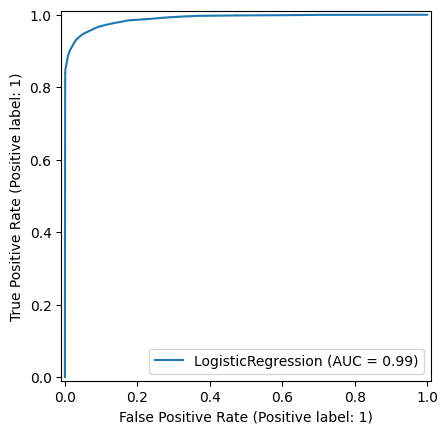

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Step 7: Train Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Step 8: Model Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
import matplotlib.pyplot as plt
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:11:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

XGBoost Confusion Matrix:
 [[56828    35]
 [    0 56863]]
XGBoost ROC AUC Score: 1.0000


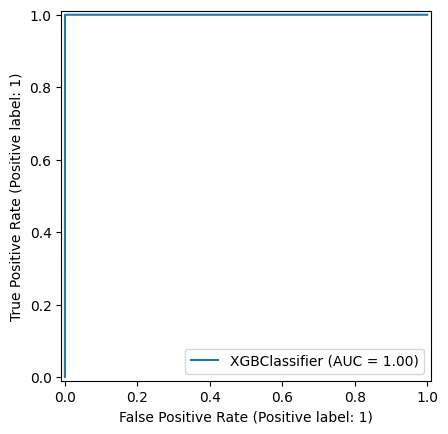

In [7]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(f"XGBoost ROC AUC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
import matplotlib.pyplot as plt
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
178/178 - 6s - 34ms/step - accuracy: 0.8995 - loss: 0.2385 - val_accuracy: 0.9608 - val_loss: 0.1008
Epoch 2/20
178/178 - 1s - 3ms/step - accuracy: 0.9578 - loss: 0.1067 - val_accuracy: 0.9714 - val_loss: 0.0725
Epoch 3/20
178/178 - 1s - 4ms/step - accuracy: 0.9674 - loss: 0.0812 - val_accuracy: 0.9799 - val_loss: 0.0533
Epoch 4/20
178/178 - 1s - 4ms/step - accuracy: 0.9757 - loss: 0.0628 - val_accuracy: 0.9849 - val_loss: 0.0392
Epoch 5/20
178/178 - 1s - 5ms/step - accuracy: 0.9819 - loss: 0.0488 - val_accuracy: 0.9910 - val_loss: 0.0286
Epoch 6/20
178/178 - 1s - 4ms/step - accuracy: 0.9869 - loss: 0.0385 - val_accuracy: 0.9946 - val_loss: 0.0215
Epoch 7/20
178/178 - 1s - 6ms/step - accuracy: 0.9905 - loss: 0.0309 - val_accuracy: 0.9963 - val_loss: 0.0163
Epoch 8/20
178/178 - 1s - 3ms/step - accuracy: 0.9930 - loss: 0.0244 - val_accuracy: 0.9971 - val_loss: 0.0132
Epoch 9/20
178/178 - 1s - 3ms/step - accuracy: 0.9943 - loss: 0.0211 - val_accuracy: 0.9976 - val_loss: 0.0106


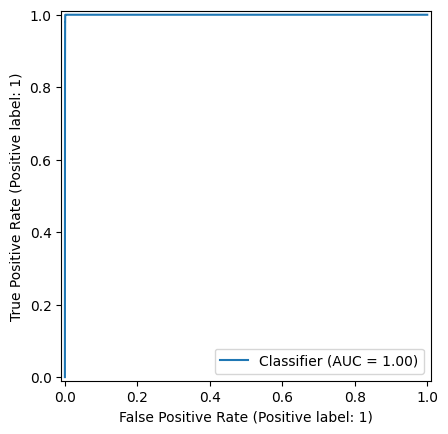

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Neural network model architecture
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = nn_model.fit(X_train, y_train, epochs=20, batch_size=2048, validation_split=0.2, verbose=2)

# Predict on test set
y_prob_nn = nn_model.predict(X_test).ravel()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

# Evaluation
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_nn))
print("Neural Network Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print(f"Neural Network ROC AUC Score: {roc_auc_score(y_test, y_prob_nn):.4f}")

# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob_nn)
plt.show()


In [9]:
# Use original dataset split for testing on realistic unbalanced data

# Separate features and labels from the original dataset (before SMOTE)
X_orig = df.drop('Class', axis=1)
y_orig = df['Class']

# Split original data into train and test sets (unbalanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_orig, test_size=0.2, random_state=42, stratify=y_orig)

# Train XGBoost on balanced training data (X_train, y_train from SMOTE)
xgb_model.fit(X_train, y_train)

# Predict on original unbalanced test set
y_pred_xgb_orig = xgb_model.predict(X_test_orig)
y_prob_xgb_orig = xgb_model.predict_proba(X_test_orig)[:, 1]

# Evaluate on unbalanced test data
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("XGBoost on Unbalanced Test Set Classification Report:\n",
      classification_report(y_test_orig, y_pred_xgb_orig))
print("XGBoost on Unbalanced Test Set Confusion Matrix:\n",
      confusion_matrix(y_test_orig, y_pred_xgb_orig))
print(f"XGBoost on Unbalanced Test Set ROC AUC Score: {roc_auc_score(y_test_orig, y_prob_xgb_orig):.4f}")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:15:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost on Unbalanced Test Set Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      1.00      0.85        98

    accuracy                           1.00     56962
   macro avg       0.87      1.00      0.92     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost on Unbalanced Test Set Confusion Matrix:
 [[56829    35]
 [    0    98]]
XGBoost on Unbalanced Test Set ROC AUC Score: 1.0000


In [13]:
import joblib

# Save the XGBoost model to a file
joblib.dump(xgb_model, 'xgb_fraud_model.joblib')

# To load later:
# xgb_model_loaded = joblib.load('xgb_fraud_model.joblib')


['xgb_fraud_model.joblib']

In [ ]:
# Save the neural network model to an HDF5 file
nn_model.save('nn_fraud_model.h5')

# To load later:
# from tensorflow.keras.models import load_model
# nn_model_loaded = load_model('nn_fraud_model.h5')


In [ ]:
# from fastapi import FastAPI
# import joblib
# import numpy as np
# from pydantic import BaseModel

# app = FastAPI()
# model = joblib.load('xgb_fraud_model.joblib')

# class Transaction(BaseModel):
#     features: list  # list of feature values

# @app.post("/predict")
# def predict_fraud(transaction: Transaction):
#     data = np.array(transaction.features).reshape(1, -1)
#     prediction = model.predict(data)
#     probability = model.predict_proba(data)[:, 1][0]
#     return {"fraud_prediction": int(prediction[0]), "fraud_probability": probability}


In [26]:
import joblib
import numpy as np

# Load the saved model
xgb_model_loaded = joblib.load('xgb_fraud_model.joblib')

# Example transaction data (use 29 feature values after preprocessing)
sample_data = np.array([
    -0.1234,   # Time_scaled
    -3.5566,   # V1
    4.9915,    # V2
    -0.6917,   # V3
    1.3210,    # V4
    -2.1410,   # V5
    3.6261,    # V6
    -0.4310,   # V7
    -0.8534,   # V8
    1.1432,    # V9
    -1.6590,   # V10
    0.3451,    # V11
    -0.4265,   # V12
    2.3127,    # V13
    -1.0220,   # V14
    0.5689,    # V15
    -3.2145,   # V16
    0.9523,    # V17
    -1.1852,   # V18
    0.6781,    # V19
    -0.9723,   # V20
    0.3214,    # V21
    -0.2345,   # V22
    1.1129,    # V23
    -2.3340,   # V24
    1.0056,    # V25
    -1.4531,   # V26
    0.7857,    # V27
    -0.7811,   # V28
    0.0350     # Amount_scaled
])

# Reshape to match model input
sample_data = sample_data.reshape(1, -1)

# Predict fraud class and probability
pred = xgb_model_loaded.predict(sample_data)
prob = xgb_model_loaded.predict_proba(sample_data)[:, 1]

print(f"Fraud Prediction: {pred[0]}")
print(f"Fraud Probability: {prob[0]:.4f}")


Fraud Prediction: 0
Fraud Probability: 0.0000
